Бутстреп (bootstrap) - это метод для оценки стандартных отклонений и нахождения доверительных интервалов статистических функционалов.
Обратим внимание на два момента:

1. Чтобы оценка стандартного отклонения была несмещённой, необходимо генерировать выборки такого же размера, как и размер исходной выборки;

2. Количество итераций бутстрепа рекомендуется брать в диапазоне от 1000 до 10000. Этого, как правило, хватает для получения достаточно точных результатов.

независимыми одинаково распределёнными случайными величинами

In [51]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
n = 1000
values = np.random.normal(90, 20, n)
mean = values.mean()
std = values.std() / np.sqrt(n)
print(f'Оценка среднего времени доставки: {mean:0.2f}')
print(f'Оценка std для среднего времени доставки: {std:0.2f}')

Оценка среднего времени доставки: 90.17
Оценка std для среднего времени доставки: 0.62


In [3]:
n = 1000            # размер исходной выборки
B = 1000            # количество генерируемых подвыборок

values = np.random.normal(90, 20, n)
quantile = np.quantile(values, 0.9)
bootstrap_quantiles = []
for _ in range(B):
    bootstrap_values = np.random.choice(values, n, True)
    bootstrap_quantiles.append(np.quantile(bootstrap_values, 0.9))
std = np.std(bootstrap_quantiles)

print(f'Оценка 90% квантиля: {quantile:0.2f}')
print(f'Оценка std для 90% квантиля: {std:0.2f}')

Оценка 90% квантиля: 114.96
Оценка std для 90% квантиля: 0.88


Зная оценку отклонения уже можно интуитивно что-то предполагать..однако есть доверительные интервалы

Доверительные интервалы

In [4]:
def get_normal_ci(bootstrap_stats, pe, alpha):
    """Строит нормальный доверительный интервал."""
    z = stats.norm.ppf(1 - alpha / 2)
    se = np.std(bootstrap_stats)
    left, right = pe - z * se, pe + z * se
    return left, right

In [5]:
def get_percentile_ci(bootstrap_stats, pe, alpha):
    """Строит перцентильный доверительный интервал."""
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

In [6]:
def get_pivotal_ci(bootstrap_stats, pe, alpha):
    """Строит центральный доверительный интервал."""
    left, right= 2 * pe - np.quantile(bootstrap_stats, [1 - alpha / 2,  alpha / 2])
    return left, right


In [7]:
n = 1000
B = 10000
alpha = 0.05

values = np.random.normal(90, 20, n)
quantile = np.quantile(values, 0.9)
bootstrap_quantiles = np.quantile(np.random.choice(values, (B, n), True), 0.9, axis=1)

In [8]:
normal_ci = get_normal_ci(bootstrap_quantiles, quantile, alpha)
percentile_ci = get_percentile_ci(bootstrap_quantiles, quantile, alpha)
pivotal_ci = get_pivotal_ci(bootstrap_quantiles, quantile, alpha)

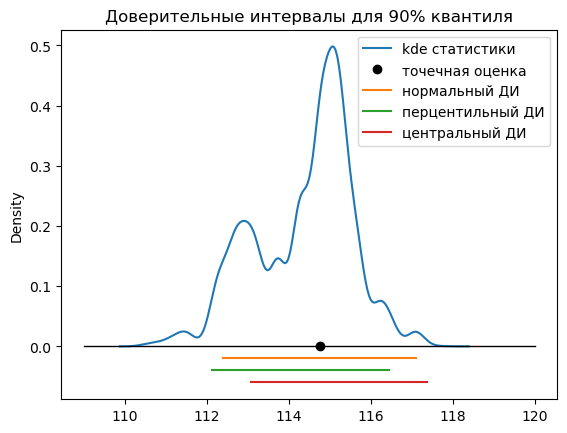

In [9]:
sns.kdeplot(bootstrap_quantiles, label='kde статистики')
plt.plot([quantile], [0], 'o', c='k', markersize=6, label='точечная оценка')
plt.plot([109, 120], [0, 0], 'k', linewidth=1)
d = 0.02
plt.plot(normal_ci, [-d, -d], label='нормальный ДИ')
plt.plot(percentile_ci, [-d*2, -d*2], label='перцентильный ДИ')
plt.plot(pivotal_ci, [-d*3, -d*3], label='центральный ДИ')

plt.title('Доверительные интервалы для 90% квантиля')
plt.legend()
plt.show()

Чтобы проверить гипотезу о равенстве квантилей на уровне значимости 5% достаточно построить 95% доверительный интервал для разности квантилей между группами. Если ноль находится вне доверительного интервала, то отличия статистически значимы, иначе нет.

Опишем ещё раз алгоритм проверки гипотез о равенстве двух произвольных метрик с помощью бутстрепа:

1.Генерируем пару подвыборок того же размера из исходных данных контрольной и экспериментальной групп;

2.Считаем метрики (реализация оценки метрики) для каждой из групп;

3.Вычисляем разность метрик, сохраняем полученное значение;

4.Повторяем шаги 1-3 от 1000 до 10000 раз;

5.Строим доверительный интервал с уровнем значимости \alpha;

Если 0 не принадлежит ДИ, то отличия статистически значимы на уровне значимости \alpha, иначе нет. 

### Применение Пример из Статьи

In [10]:
n = 1000
B = 10000
alpha = 0.05

values_a = np.random.normal(90, 20, n)
values_b = np.random.normal(90, 15, n)

pe = np.quantile(values_b, 0.9) - np.quantile(values_a, 0.9)
bootstrap_values_a = np.random.choice(values_a, (B, n), True)
bootstrap_metrics_a = np.quantile(bootstrap_values_a, 0.9, axis=1)
bootstrap_values_b = np.random.choice(values_b, (B, n), True)
bootstrap_metrics_b = np.quantile(bootstrap_values_b, 0.9, axis=1)
bootstrap_stats = bootstrap_metrics_b - bootstrap_metrics_a
ci = get_percentile_ci(bootstrap_stats, pe, alpha)
has_effect = not (ci[0] < 0 < ci[1])

print(f'Значение 90% квантиля изменилось на: {pe:0.2f}')
print(f'{((1 - alpha) * 100)}% доверительный интервал: ({ci[0]:0.2f}, {ci[1]:0.2f})')
print(f'Отличия статистически значимые: {has_effect}')

Значение 90% квантиля изменилось на: -7.48
95.0% доверительный интервал: (-9.84, -4.48)
Отличия статистически значимые: True


### Мой пример

In [27]:
n = 1000
B = 10000
alpha = 0.05

values_a = np.random.normal(700, 20, n)
values_b = np.random.normal(711, 20, n)

pe = np.mean(values_b) - np.mean(values_a)
bootstrap_values_a = np.random.choice(values_a, (B, n), True)
bootstrap_metrics_a = np.mean(bootstrap_values_a, axis=1)

bootstrap_values_b = np.random.choice(values_b, (B, n), True)
bootstrap_metrics_b = np.mean(bootstrap_values_b, axis=1)
bootstrap_stats = bootstrap_metrics_b - bootstrap_metrics_a


z = stats.norm.ppf(1 - alpha / 2)
se = np.std(bootstrap_stats)
ci = [pe - z * se, pe + z * se]

has_effect = not (ci[0] <0 < ci[1])

print(f'Значение разницы средних: {pe:0.2f}')
print(f'{((1 - alpha) * 100)}% доверительный интервал: ({ci[0]:0.2f}, {ci[1]:0.2f})')
print(f'Отличия статистически значимые: {has_effect}')

Значение разницы средних: 11.32
95.0% доверительный интервал: (9.59, 13.05)
Отличия статистически значимые: True


### Тест Стьююдента для СВЯЗАННЫХ ДАНЫХ

In [28]:
alpha = 0.05              # допустимая вероятность ошибки I рода
sample_size = 1000        # размер групп

In [29]:
def plot_pvalue_distribution(dict_pvalues):
    """Рисует графики распределения p-value."""
    X = np.linspace(0, 1, 1000)
    for name, pvalues in dict_pvalues.items():
        Y = [np.mean(pvalues < x) for x in X]
        plt.plot(X, Y, label=name)

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Оценка распределения p-value', size=16)
    plt.xlabel('p-value', size=12)
    plt.legend(fontsize=12)
    plt.grid()
    plt.show()

def generate_data(sample_size, effect):
    """Генерирует данные со стоимостью покупок.

    Возвращает два списка с данными контрольной и экспериментальной групп.
    Элементы списков - множества со стоимостями покупок пользователей. 
    """
    result = []
    for group_effect in [0, effect]:
        n_purchases = np.random.randint(1, 5, sample_size)
        mean_costs = np.random.uniform(1000, 2000, sample_size)
        data = [
            np.random.normal(mean + group_effect, 200, n)
            for n, mean in zip(n_purchases, mean_costs)
        ]
        result.append(data)
    return result

Доля ошибок первого рода: 0.22


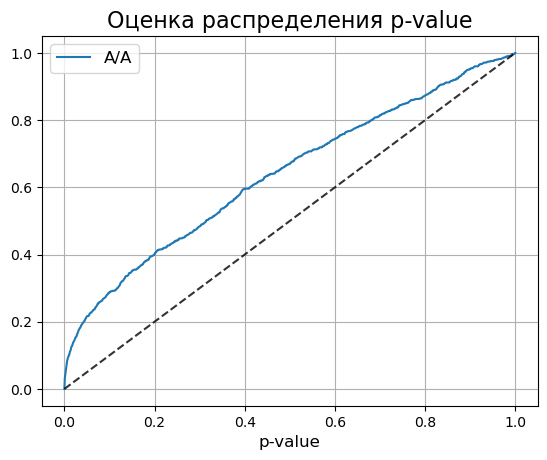

In [30]:
pvalues = []
for _ in range(1000):
    a, b = generate_data(sample_size, 0)
    a_values = np.hstack(a)
    b_values = np.hstack(b)
    pvalue = stats.ttest_ind(a_values, b_values).pvalue
    pvalues.append(pvalue)

error_rate = np.mean(np.array(pvalues) < alpha)
print(f'Доля ошибок первого рода: {error_rate:0.2f}')
plot_pvalue_distribution({'A/A': pvalues})

### ПРИМЕНИМ БУТСТРАП

In [39]:
def get_percentile_ci(bootstrap_stats, alpha):
    """Строит перцентильный доверительный интервал."""
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

def check_bootsrtap(a, b, n_iter, alpha):
    """Оценивает значимость отличий с помощью бутстрепа.

    Если отличия значимые, то возвращает 1, иначе 0.
    """
    # вычисляем стоимость и количество покупок клиентов
    xy_a = np.array([[sum(values), len(values)] for values in a])
    xy_b = np.array([[sum(values), len(values)] for values in b])
    # генерируем случайные индексы для выбора подмножеств данных
    len_a = len(a)
    len_b = len(b)
    indexes_a = np.random.choice(
        np.arange(len_a), size=(n_iter, len_a), replace=True
    )
    indexes_b = np.random.choice(
        np.arange(len_b), size=(n_iter, len_b), replace=True
    )

    bootstrap_stats = []
    for idx_a, idx_b in zip(indexes_a, indexes_b):
        bootstrap_xy_a = xy_a[idx_a]
        bootstrap_xy_b = xy_b[idx_b]
        # считаем разницу метрик отношения
        bootstrap_stat = (
            bootstrap_xy_b[:, 0].sum() / bootstrap_xy_b[:, 1].sum()
            - bootstrap_xy_a[:, 0].sum() / bootstrap_xy_a[:, 1].sum()
        )
        bootstrap_stats.append(bootstrap_stat)
    # строим доверительный интервал и оцениваем значимость отличий
    ci = get_percentile_ci(bootstrap_stats, alpha)
    has_effect = 1 - (ci[0] < 0 < ci[1])
    return has_effect

alpha = 0.05               # допустимая вероятность ошибки I рода
sample_size = 1000         # размер групп
n_iter = 1000              # количество итераций бутстрепа

effects = []
for _ in range(1000):
    a, b = generate_data(sample_size, 0)
    has_effect = check_bootsrtap(a, b, n_iter, alpha)
    effects.append(has_effect)

error_rate = np.mean(np.array(effects) == 1)
print(f'Доля ошибок первого рода: {error_rate:0.3f}')

Доля ошибок первого рода: 0.058


### Преобразуем в DF и обратно в np

In [136]:
a, b = generate_data(sample_size, 0)
g = [[1+k for j in range(len(i))] for k,i in enumerate(a)]
a_values = np.hstack(a)
id = np.hstack(g)
df = pd.DataFrame({'user_id':id, 'cost':a_values})

In [138]:
agg_df = df.groupby('user_id', as_index=False).agg({'cost': 'sum', 'user_id': 'count'}).rename(columns={'cost': 'total_cost', 'user_id': 'num_transactions'})
agg= agg_df.values

# ДЕЛЬТА_МЕТОД

In [178]:
def check_delta_method(a, b):
    """Проверка гипотезы с помощью дельта-метода.

    Возвращает p-value.
    """
    dict_ = {}
    for data, group_name in [(a, 'a',), (b, 'b',)]:
        n_user = len(data)
        array_x = np.array([np.sum(row) for row in data])
        array_y = np.array([len(row) for row in data])
        mean_x, mean_y = np.mean(array_x), np.mean(array_y)
        var_x, var_y = np.var(array_x), np.var(array_y)
        cov_xy = np.cov(array_x, array_y)[0, 1]
        # точечная оценка метрики
        pe_metric = np.sum(array_x) / np.sum(array_y)
        # оценка дисперсии метрики
        var_metric = (
            var_x / mean_y ** 2
            - 2 * (mean_x / mean_y ** 3) * cov_xy
            + (mean_x ** 2 / mean_y ** 4) * var_y
        ) / n_user
        dict_[f'pe_metric_{group_name}'] = pe_metric
        dict_[f'var_metric_{group_name}'] = var_metric
    var = dict_['var_metric_a'] + dict_['var_metric_b']
    delta = dict_['pe_metric_b'] - dict_['pe_metric_a']
    t = delta / np.sqrt(var)
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

In [185]:
alpha = 0.05           # допустимая вероятность ошибки I рода
sample_size = 1000     # размер групп
effect = -50            # размер эффекта

In [186]:
pvalues_aa = []
pvalues_ab = []

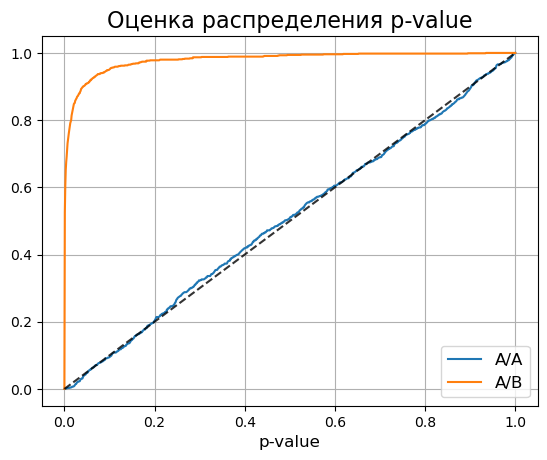

In [187]:
for _ in range(1000):
    a, b = generate_data(sample_size, 0)
    pvalues_aa.append(check_delta_method(a, b))
    a, b = generate_data(sample_size, effect)
    pvalues_ab.append(check_delta_method(a, b))

plot_pvalue_distribution({'A/A': pvalues_aa, 'A/B': pvalues_ab}) #количество p-value меньше чем Х

In [198]:
error_rate  = np.mean(np.array(pvalues_aa)<alpha)

In [199]:
print(f'Доля ошибок первого рода: {error_rate:0.2f}')

Доля ошибок первого рода: 0.05
